# Scikit-Learn 朴素贝叶斯分类

朴素贝叶斯分类是机器学习中常见的分类方法之一，本节将带大家深入学习一下 Scikit-Learn 中朴素贝叶斯分类工具包的相关使用方法。
首先，我们导入相关的库，并构建第一个示例数据集：

In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

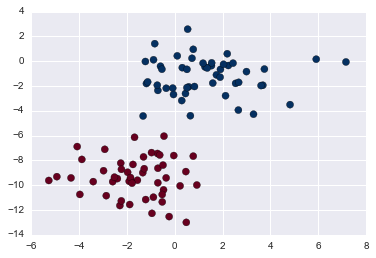

In [27]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

Scikit-Learn 中的 make_blobs 方法常被用来生成聚类算法的测试数据，直观地说，make_blobs 会根据用户指定的特征数量、中心点数量、范围等来生成几类数据，这些数据可用于测试聚类算法的效果。接下来，我们导入朴素贝叶斯分类函数 GaussianNB ，构建并拟合模型：

In [28]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

为了更清晰直观地展示模型效果，我们构建了另一组随机样本，用于观察朴素贝叶斯分类模型在二维空间中的分类边界，在这里，我们可以调用 predict 函数，来输出模型对样本点的判断结果：

In [29]:
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

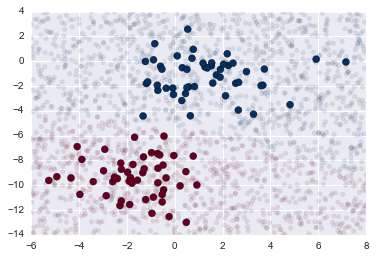

In [30]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim);

我们在分类中看到一个略微弯曲的边界 - 一般来说，高斯朴素贝叶斯的边界是二次的。

这个贝叶斯形式的一个好处是，它自然支持概率分类，我们可以使用predict_proba方法计算：

In [31]:
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)

array([[ 0.89,  0.11],
       [ 1.  ,  0.  ],
       [ 1.  ,  0.  ],
       [ 1.  ,  0.  ],
       [ 1.  ,  0.  ],
       [ 1.  ,  0.  ],
       [ 0.  ,  1.  ],
       [ 0.15,  0.85]])

这些列分别提供了第一个和第二个标签的后验概率。 如果您正在寻找分类中的不确定性估计，这样的贝叶斯方法可能是有用的方法。

当然，最终的分类只会与产生它的模型假设一样好，这就是高斯朴素的贝叶斯经常不会产生优秀结果的原因。 然而，在许多情况下，特别是随着特征数量的增加，这一假设并不足以阻止高斯朴素贝叶斯成为有用的方法。

# 多项式朴素贝叶斯

刚刚描述的高斯假设，绝不是唯一的简单假设，可以用于指定每个标签的生成分布。 另一个有用的例子是多项式朴素贝叶斯，其中假设特征从简单的多项式分布生成。 多项式分布描述了在多个类别中观察计数的概率，因此多项朴素贝叶斯最适合于表示计数或计数率的特征。

这个想法与以前一样，除了我们不用最佳拟合高斯模型，而用最合适的多项式分布，对数据分布建模。

## 示例：文本分类

经常使用多项朴素贝叶斯的一个地方是文本分类，其特征与要分类的文档中的字数或频率有关。 我们在特征工程中讨论了这些特征的提取; 在这里，我们将使用 20 个新闻组语料库中的稀疏字数特征，来展示我们如何将这些简短文档分类。

让我们下载数据并查看目标名称：

In [32]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

为了简化，我们选择这些分类中的一些，之后下载测试集。

In [33]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

数据样本呈如下形式，包含了一篇网络消息的来源、机构等诸多信息：

In [34]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



为了将这些数据用于机器学习，我们需要将每个字符串的内容转换为数值向量。 为此，我们将使用 TF-IDF 向量化器（在特征工程中讨论），并创建一个流水线，将其附加到多项朴素贝叶斯分类器：

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

使用这个流水线，我们可以将模型用于训练数据，并测试数据的预测标签。

In [36]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

在我们已经预测了测试数据的标签，我们可以评估它们来了解估计器的性能。 例如，这里是测试数据的真实和预测标签之间的混淆矩阵：

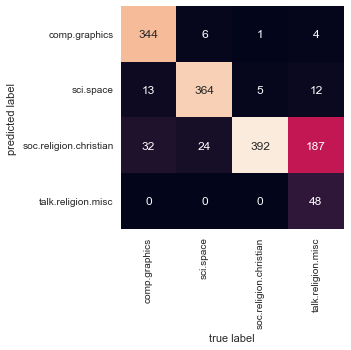

In [37]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

显然，即使这个非常简单的分类器，也可以成功将空间话题与电脑话题分开，但是在宗教话题和基督教话题之间会混淆。 这是预期的混乱。

这里非常酷，我们现在有了工具，用于确定任何字符串的分类，使用这个流水线的predict()方法。 这是一个简便的工具函数，它返回单个字符串的预测：

In [38]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

让我们试试看：

In [39]:
predict_category('sending a payload to the ISS')

'sci.space'

In [40]:
predict_category('discussing islam vs atheism')

'soc.religion.christian'

In [41]:
predict_category('determining the screen resolution')

'comp.graphics'

# 何时使用朴素贝叶斯

因为朴素的贝叶斯分类器对数据做出了如此严格的假设，所以它们通常不会和更复杂的模型一样好。 也就是说，它们有几个优点：

- 训练和预测都非常快
- 提供简单的概率预测
- 经常很容易解释
- 具有很少的（如果存在）可调参数

这些优点意味着，朴素的贝叶斯分类器通常是初始基本分类的不错选择。 如果适当使用，那么恭喜：对于你的问题，你有一个非常快速，可解释的分类器。 如果表现不佳，那么您可以开始探索更复杂的模型，使用一些基本知识，了解应该如何进行。

朴素贝叶斯分类器在以下情况之一中往往表现得特别好：

- 朴素的假设实际匹配数据时（在实践中非常罕见）
- 对于分隔良好的分类，当模型复杂性不太重要时
- 对于非常高维的数据，当模型复杂度不太重要时

最后两点看起来是截然不同的，但它们实际上是相关的：随着数据集的维度越来越大，任何两点不可能更接近（毕竟，它们必须在每一个维度上都接近）。 这意味着，如果新维度添加了实际的信息，平均来讲，高维度的簇比低维度更加分散。 因此，随着维度增加，像朴素贝叶斯这样的简单分类器，往往比复杂分类器有效：一旦你拥有足够的数据，即使一个简单的模型也是非常强大的。